In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import torch
fp=glob.glob('output_land_patches/patches_*.nc')
fp=sorted(fp)
land_fractL=[]
tc_L=[]
sfc_type_L=[]
sk_temp_L=[]
sk_temp1_L=[]
xenc_L=[]
xenc_prec_L=[]
oe_wvp_L=[]
near_sfc_precip_L=[]
sfc_emiss_L=[]
cldw_oe_L=[]
sfc_bin_L=[]
qv_L=[]
import pickle

#dense_autoencoder=torch.jit.load('dense_autoencoder.pt')
#with open('scaler_qv.pkl','wb') as f:
#    pickle.dump(scaler_qv,f)
#scripted_model = torch.jit.script(model)
#scripted_model.save('dense_autoencoder.pt')
scaler_qv=pickle.load(open('scaler_land_qv.pkl','rb'))
dense_autoencoder=torch.jit.load('dense_autoencoder_land.pt')


In [3]:
land_fractL=[]
tc_L=[]
sfc_type_L=[]
sk_temp_L=[]
sk_temp1_L=[]
xenc_L=[]
x_env_enc_L=[]
xenc_prec_L=[]
oe_wvp_L=[]
near_sfc_precip_L=[]
sfc_emiss_L=[]
cldw_oe_L=[]
sfc_bin_L=[]
qv_L=[]
for f in fp[::]:
    with nc.Dataset(f) as df:
        tc_s1=df['tc_s1'][:]
        tc_s2=df['tc_s2'][:]
        surface_type=df['surface_type'][:]
        sk_temp=df['sk_temp'][:]
        qv=df['qv'][:]
        qv_oe=df['qv_oe'][:]
        cldw_oe=df['cldw_oe'][:]
        oe_wvp=df['oe_wvp'][:]
        near_sfc_precip=df['near_sfc_precip'][:]
        sfc_emiss=df['sfc_emiss'][:]
        sfc_bin=df['sfc_bin'][:]
        x_enc_prec=df['x_enc'][:]
        #break
        if (qv_oe.data.min()<0):
            continue
        if sk_temp.data.min()<0:
            continue

        sk_temp1_L.extend(sk_temp[:,:,:].flatten())
        qv_L.extend(qv_oe[:,:,:,:].reshape(-1,10))
        sfc_bin_L.extend(sfc_bin[:,:,:].flatten())
        #continue
        x_qv=np.concatenate((sk_temp[:,:,:,np.newaxis],qv_oe[:,:,:,:]),axis=-1)
        x_qv_env=np.concatenate((sk_temp[:,:,:,np.newaxis],qv[:,:,:,:]),axis=-1)
        nt,nx,ny,nz=x_qv.shape
        x_qv=x_qv.reshape(-1,11)
        x_qv_scaled=(x_qv-scaler_qv['mean'])/scaler_qv['std']
        x_qv_env_scaled=(x_qv_env-scaler_qv['mean'])/scaler_qv['std']
        x_enc=dense_autoencoder.encoder(torch.tensor(x_qv_scaled,dtype=torch.float32)).detach().numpy()
        x_env_enc=dense_autoencoder.encoder(torch.tensor(x_qv_env_scaled,dtype=torch.float32)).detach().numpy()
        x_enc=x_enc.reshape(nt,nx,ny,4)
        x_env_enc=x_env_enc.reshape(nt,nx,ny,4)
        
        for i in range(surface_type.shape[0]):
            a=np.nonzero(surface_type[i,:,:]!=0)
            land_fractL.append(len(a[0])/(128*49))
            if len(a[0])/(128*49)>0.5:
                a=np.nonzero(near_sfc_precip[i,:,:].data<0)
                if len(a[0])>0:
                    continue
                a=np.nonzero(oe_wvp[i,:,:].data<0)
                if len(a[0])>0:
                    continue
                tc_L.append(np.concatenate((tc_s1[i,:,:,:],tc_s2[i,:,:,:]),axis=-1))
                sfc_type_L.append(surface_type[i,:,:])
                sk_temp_L.append(sk_temp[i,:,:])
                xenc_L.append(x_enc[i,:,:,:])
                x_env_enc_L.append(x_env_enc[i,:,:,:])
                xenc_prec_L.append(x_enc_prec[i,:,:,:])
                oe_wvp_L.append(oe_wvp[i,:,:])
                sfc_emiss_L.append(sfc_emiss[i,:,:,:])
                near_sfc_precip_L.append(np.log10(1+near_sfc_precip[i,:,:]/0.1))
        #break
    #break

In [12]:
x_data=np.concatenate((np.array(sk_temp1_L)[:,np.newaxis],np.array(qv_L)[:,:]),axis=-1)
#scaler_qv={'mean':x_mean,'std':x_std}
scaler_qv=pickle.load(open('scaler_ocean_qv.pkl','rb'))
print(scaler_qv['mean'],scaler_qv['std'])
print(x_data.mean(axis=0),x_data.std(axis=0))
x_data_mean=x_data.mean(axis=0)
x_data_std=x_data.std(axis=0)
x_data_scaled=(x_data-x_data_mean)/x_data_std

[2.8688474e+02 2.5371223e-04 9.1984117e-04 6.5645538e-02 2.2326896e-01
 5.6570786e-01 1.5656673e+00 4.1181731e+00 6.8262706e+00 8.7204018e+00
 1.1938538e+01] [1.1666225e+01 8.9217763e-04 2.1327066e-03 9.1498114e-02 2.9274026e-01
 7.4359059e-01 1.6207964e+00 3.3232927e+00 4.8432231e+00 5.6665807e+00
 8.1601381e+00]
[2.73627777e+02 1.04256265e-04 5.02366689e-04 5.43274507e-02
 1.86799332e-01 5.27661383e-01 1.46524429e+00 3.48077559e+00
 4.97181559e+00 5.85966921e+00 6.86954451e+00] [2.3817369e+01 5.2453484e-04 2.0886895e-03 9.5530659e-02 2.9378471e-01
 7.7149200e-01 1.7600244e+00 3.6383307e+00 5.1982393e+00 6.1484447e+00
 7.5614481e+00]


40
0.0
0.0
0.0
0.0
0.0
0.0


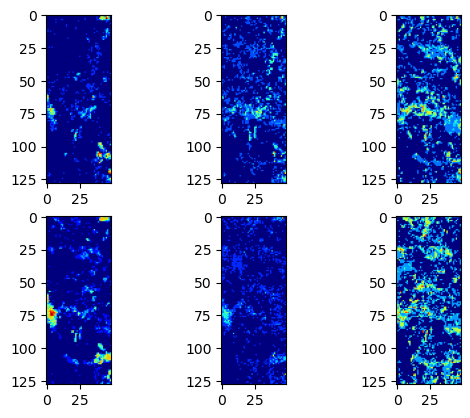

In [20]:
print(len(tc_L))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.array(xenc_prec_L).std(axis=0)[:,:,i],cmap='jet')   
    print(np.array(xenc_prec_L).std(axis=0).min())

In [88]:
for i in range(6):
    print(np.corrcoef(np.array(xenc_prec_L)[:,:,:,i].flatten(),np.array(near_sfc_precip_L).flatten()))

[[ 1.         -0.40180597]
 [-0.40180597  1.        ]]
[[ 1.         -0.32199015]
 [-0.32199015  1.        ]]
[[1.         0.40016355]
 [0.40016355 1.        ]]
[[ 1.        -0.6229669]
 [-0.6229669  1.       ]]
[[1.         0.30338857]
 [0.30338857 1.        ]]
[[1.         0.59326217]
 [0.59326217 1.        ]]


In [10]:
# define simple autoencoder using dense layers in pytorch

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

class DenseAutoEncoder(nn.Module):
    """
    Simple autoencoder with dense layers
    """
    def __init__(self,n_in, n_out, n_pc):
        super(DenseAutoEncoder, self).__init__()
        self.n_in=n_in
        self.n_out=n_out
        self.n_pc=n_pc
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 12),
            nn.ReLU(True),
            nn.Linear(12, 12),
            nn.ReLU(True),
            nn.Linear(12, n_pc),
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_pc, 12),
            nn.ReLU(True),
            nn.Linear(12, 12),
            nn.ReLU(True),
            nn.Linear(12, n_out),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
n_in=11
n_out=11
n_pc=4
dense_autoencoder = DenseAutoEncoder(n_in, n_out, n_pc)
x_in=torch.randn(10, 11)
x_out=dense_autoencoder(x_in)

In [13]:
import numpy as np
import torch.optim as optim
# Assuming x_data_scaled is already loaded
# Example: x_data_scaled = np.load('path_to_x_data_scaled.npy')

# Select every 10th element from x_data_scaled
selected_data = x_data_scaled[::10]

# Split the selected data into training and validation sets
split_index = len(selected_data) // 2
train_data = torch.tensor(selected_data[:split_index], dtype=torch.float32)
test_data = torch.tensor(selected_data[split_index:], dtype=torch.float32)

criterion = nn.MSELoss()
# Reshape the data to match the input shape of the autoencoder
train_data = train_data.view(train_data.size(0), -1)
test_data = test_data.view(test_data.size(0), -1)
model=dense_autoencoder
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 30
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    avg_loss = 0.   
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss = avg_loss / len(train_data)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/30], Loss: 0.0074
Epoch [2/30], Loss: 0.0032
Epoch [3/30], Loss: 0.0029
Epoch [4/30], Loss: 0.0024
Epoch [5/30], Loss: 0.0019
Epoch [6/30], Loss: 0.0018
Epoch [7/30], Loss: 0.0019
Epoch [8/30], Loss: 0.0017
Epoch [9/30], Loss: 0.0015
Epoch [10/30], Loss: 0.0014
Epoch [11/30], Loss: 0.0013
Epoch [12/30], Loss: 0.0014
Epoch [13/30], Loss: 0.0013
Epoch [14/30], Loss: 0.0013
Epoch [15/30], Loss: 0.0013
Epoch [16/30], Loss: 0.0013
Epoch [17/30], Loss: 0.0012
Epoch [18/30], Loss: 0.0012
Epoch [19/30], Loss: 0.0012
Epoch [20/30], Loss: 0.0012
Epoch [21/30], Loss: 0.0011
Epoch [22/30], Loss: 0.0011
Epoch [23/30], Loss: 0.0011
Epoch [24/30], Loss: 0.0011
Epoch [25/30], Loss: 0.0010
Epoch [26/30], Loss: 0.0010
Epoch [27/30], Loss: 0.0010
Epoch [28/30], Loss: 0.0011
Epoch [29/30], Loss: 0.0011
Epoch [30/30], Loss: 0.0011


In [15]:
import pickle
scaler_qv={'mean':x_data_mean,'std':x_data_std}
with open('scaler_land_qv.pkl','wb') as f:
    pickle.dump(scaler_qv,f)
scripted_model = torch.jit.script(model)
scripted_model.save('dense_land_autoencoder.pt')

In [4]:
var_L=[]
norm_param_L=[]
for vars in [tc_L,sfc_type_L,sk_temp_L,oe_wvp_L,near_sfc_precip_L,xenc_L,xenc_prec_L,x_env_enc_L]:
    mean_var=np.mean(np.array(vars),axis=0)
    std_var=np.std(np.array(vars),axis=0)
    var_norm=(np.array(vars)-mean_var)/std_var
    var_L.append(var_norm)
    norm_param_L.append([mean_var,std_var])
X=np.concatenate((var_L[0],var_L[1][:,:,:,np.newaxis],var_L[2][:,:,:,np.newaxis],var_L[7][:,:,:,:]),axis=-1)
y=np.concatenate((var_L[3][:,:,:,np.newaxis],var_L[4][:,:,:,np.newaxis],var_L[5][:,:,:,:],var_L[6][:,:,:,:]),axis=-1)
vars_string=['tc','sfc_type','sk_temp','oe_wvp','near_sfc_precip','xenc','xenc_prec','xenv_enc']
dict_scaler={"vars":vars_string,"norm_param":norm_param_L}
import pickle
with open('norm_param_150_land.pkl','wb') as f:
    pickle.dump(dict_scaler,f)


In [5]:
import xarray as xr
x_arr=xr.DataArray(X.astype(np.float32),dims=['time','nx','ny','n_in'],coords={'time':range(X.shape[0]),'nx':range(X.shape[1]),'ny':range(X.shape[2]),'n_in':range(X.shape[3])})
y_arr=xr.DataArray(y.astype(np.float32),dims=['time','nx','ny','n_out'],coords={'time':range(y.shape[0]),'nx':range(y.shape[1]),'ny':range(y.shape[2]),'n_out':range(y.shape[3])})

comp = dict(zlib=True, complevel=5)
ds=xr.Dataset({'X':x_arr,'y':y_arr})
ds.to_netcdf('training_data_150_land.nc',encoding={'X': comp,'y': comp})

In [121]:
print(X.shape)
print(y.shape)
print(np.array(oe_wvp_L).min())
a=np.nonzero(np.array(oe_wvp_L)<0)
print(len(a[0])/len(oe_wvp_L)/128/49)

(2996, 128, 49, 15)
(2996, 128, 49, 2)
0.0
0.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_channels, nf,latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, nf, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(nf, nf*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(nf*2, nf*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Conv2d(nf*4, latent_dim, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        z = self.fc(x3)
        return z, [x1, x2, x3]

class Decoder(nn.Module):
    def __init__(self, latent_dim, nf, out_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Conv2d(latent_dim, nf*4, kernel_size=3, padding=1)
        self.deconv1 = nn.ConvTranspose2d(nf*4, nf*2, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nf*2, nf, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(nf, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, z):
        x = self.fc(z)
        x = F.relu(self.deconv1(self.upsample(x)))
        x = F.relu(self.deconv2(self.upsample(x)))
        x_hat =self.deconv3(x)
        return x_hat

class Regressor(nn.Module):
    def __init__(self, latent_dim, nf, out_channels):
        super(Regressor, self).__init__()
        self.fc = nn.Conv2d(latent_dim, nf*4, kernel_size=3, padding=1)
        self.conv1 = nn.ConvTranspose2d(nf*4+nf*2, nf*2, kernel_size=3, padding=1)
        self.conv2 = nn.ConvTranspose2d(nf*2+nf, nf, kernel_size=3, padding=1)
        self.conv3 = nn.ConvTranspose2d(nf, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, z, intermediate_outputs):
        x1, x2, x3 = intermediate_outputs
        x = self.fc(z)
        x = self.upsample(x)
        #print(x.shape,x2.shape)
        x = torch.concat([x, x2], dim=1)
        x = F.relu(self.conv1(x))
        x = self.upsample(x)
        x = torch.concat([x, x1], dim=1)
        #print(x.shape,'[x,x1]')
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        y_hat = x
        return y_hat

class HybridModel(nn.Module):
    def __init__(self, in_channels, nf, latent_dim, rec_channels, out_channels):
        super(HybridModel, self).__init__()
        self.encoder = Encoder(in_channels, nf, latent_dim)
        self.decoder = Decoder(latent_dim, nf, rec_channels)
        self.regressor = Regressor(latent_dim, nf, out_channels)

    def forward(self, x):
        z, intermediate_outputs = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.regressor(z, intermediate_outputs)
        return x_hat, y_hat

# Example usage
in_channels = 29
rec_channels = 13
latent_dim = 128
out_channels = 9
#model = HybridModel(in_channels, latent_dim, out_channels)
nx = 128
ny = 48
nf = 16
model_encoder = Encoder(in_channels, nf, latent_dim)
model_decoder = Decoder(latent_dim, nf, out_channels)
# Example input
x = torch.randn(1, in_channels, 128, 64)
#x_hat = model(x)
z, intermediate_outputs = model_encoder(x)

#print(x_hat.shape)
#print(z.shape)
#for x in intermediate_outputs:
#    print('int_shape',x.shape)

hybrid_model = HybridModel(in_channels, nf, latent_dim, rec_channels,out_channels)
torch.onnx.export(hybrid_model, x, "hybrid_model.onnx", verbose=True, input_names = ['input'], output_names = ['output1', 'output2'])

Exported graph: graph(%input : Float(1, 16, 128, 64, strides=[131072, 8192, 64, 1], requires_grad=0, device=cpu),
      %encoder.conv1.weight : Float(16, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv1.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %encoder.conv2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv2.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %encoder.conv3.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv3.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %encoder.fc.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.fc.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %decoder.fc.weight : Float(64, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu),
      %decoder.fc.bias : Float(64, strides=[1],

In [122]:
import torch
n_all=X.shape[0]
nt=int(n_all*0.8)
X_torch=torch.tensor(X[:,:,:48,:],dtype=torch.float32)
y_torch=torch.tensor(y[:,:,:48,:],dtype=torch.float32)
X_torch=X_torch.permute(0,3,1,2)
y_torch=y_torch.permute(0,3,1,2)
#mask_torch=torch.tensor(mask_y[:nt],dtype=torch.float32) 
model = HybridModel(in_channels=15, nf=16, latent_dim=16, rec_channels=13,out_channels=2)
dataset = torch.utils.data.TensorDataset(X_torch[:nt], y_torch[:nt])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [128]:
n_epochs = 5
for epoch in range(n_epochs):
    avg_loss = 0
    for inputs, target in dataloader:
        optimizer.zero_grad()
        outputs, y_ = model(inputs)
        loss1 = criterion(outputs, inputs[:,:13,:,:])
        loss2 = criterion(y_, target)
        loss=loss1+loss2
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss/len(dataloader)}")

Epoch 1/5, Loss: 0.3032074703772863
Epoch 2/5, Loss: 0.3113872617483139
Epoch 3/5, Loss: 0.3001754738887151
Epoch 4/5, Loss: 0.2966721016168594
Epoch 5/5, Loss: 0.28765505492687227


In [135]:
y_rec, y_pred = model(X_torch[nt:])
y_pred_np=y_pred.detach().numpy()
y_target_np=y_torch.detach().numpy()
a_land=np.nonzero(np.array(sfc_type_L[nt:])[:,:,:48]>0.01)
print(np.corrcoef(y_pred_np[:,0,:,:][a_land],y_target_np[nt:,0,:,:][a_land]))

[[1.         0.95892529]
 [0.95892529 1.        ]]


In [77]:
print(var_L[-1].min(),var_L[-1].max())
print(np.array(sfc_emiss_L).min(),np.array(sfc_emiss_L).max())

-7.4919124 3.581701
0.20863369 1.1


[[1. 1.]
 [1. 1.]]


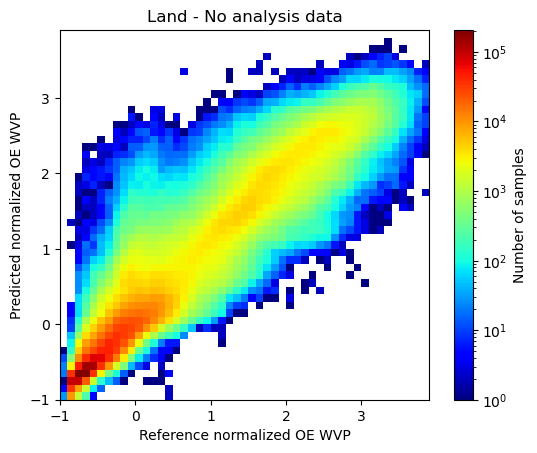

In [139]:
print(np.corrcoef(y_target_np[nt:,0,:,:].flatten(),var_L[3][nt:,:,:48].flatten()))
import matplotlib.colors
ax=plt.subplot(111)
h2=plt.hist2d(y_target_np[nt:,0,:,:][a_land].flatten(),y_pred_np[:,0,:,:][a_land].flatten(),bins=np.arange(-1,4,0.1),cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.xlabel('Reference normalized OE WVP')
plt.ylabel('Predicted normalized OE WVP')
plt.title('Land - No analysis data')
plt.colorbar(h2[3],label='Number of samples')
plt.savefig('joint_hist_oewvp_land.png',dpi=300)
#plt.figure()
#plt.hist2d(y_target_np[nt:,0,:,:].flatten(),var_L[3][nt:,:,:48].flatten(),bins=50,cmap='jet',norm=matplotlib.colors.LogNorm())

In [143]:
(y_target_np[nt:,0,:,:][a_land].flatten()-y_pred_np[:,0,:,:][a_land].flatten()).std()**2
0.03**0.5

0.17320508075688773